# GluonTS - Transfer Learning Approach (quarterly) 

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_quarterly_atm`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_quarterly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports



In [3]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [6]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

## Check the data

In [7]:
dataname_a = "m4_quarterly_atm"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.


24000

In [8]:
dataname_b1 = "m4_quarterly_macro"
dataset_b1 = get_dataset(dataname_b1, regenerate=False)
len(dataset_b1.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_macro.


5315

In [9]:
dataname_b2 = "m4_quarterly_micro"
dataset_b2 = get_dataset(dataname_b2, regenerate=False)
len(dataset_b2.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_micro.


6020

In [10]:
dataname_b3 = "m4_quarterly_other"
dataset_b3 = get_dataset(dataname_b3, regenerate=False)
len(dataset_b3.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_other.


865

In [11]:
dataname_b4 = "m4_quarterly_finance"
dataset_b4 = get_dataset(dataname_b4, regenerate=False)
len(dataset_b4.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_finance.


5305

In [12]:
dataname_b5 = "m4_quarterly_industry"
dataset_b5 = get_dataset(dataname_b5, regenerate=False)
len(dataset_b5.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_industry.


4637

In [13]:
dataname_b6 = "m4_quarterly_demographic"
dataset_b6 = get_dataset(dataname_b6, regenerate=False)
len(dataset_b6.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.


1858

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 24000
length test: 24000

start:
 1750-01-31 00:00:00
target:
 [7407.412  7528.566  7374.709  7395.5146 7654.008  7686.8477 7578.191
 7904.3765 7744.0493 7889.909 ]
feat_static_cat:
 [1]


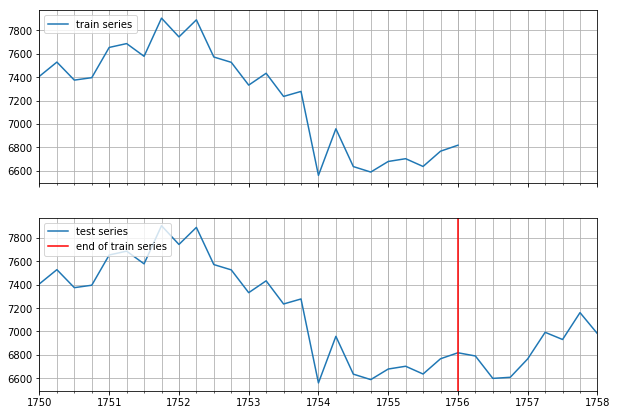

In [14]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 5315
length test: 5315

start:
 1750-01-31 00:00:00
target:
 [7407.412  7528.566  7374.709  7395.5146 7654.008  7686.8477 7578.191
 7904.3765 7744.0493 7889.909 ]
feat_static_cat:
 [1]


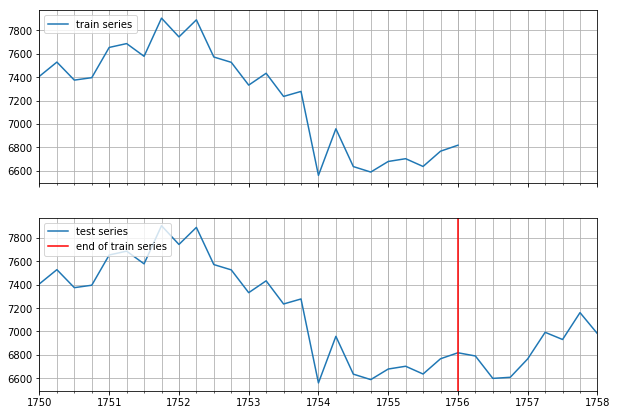

In [15]:
dataset_b = dataset_b1

train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [16]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [17]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [18]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=MetaData(freq='3M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='24000')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=8), train=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf749b0>, test=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf28588>)

 TrainDatasets(metadata=MetaData(freq='3M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='5315')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=8), train=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf28ac8>, test=<gluonts.dataset.common.FileDataset object at 0x7f5cbbf28978>)


In [19]:
print(dataname_a)
print(dataname_b1)

m4_quarterly_atm
m4_quarterly_macro


In [20]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [21]:
print(dataname_a)
print(dataname_b1)

m4_quarterly_atm
m4_quarterly_macro


## Study 1: `m4_quarterly_atm` vs. `m4_quarterly_macro` trained network

- Alternating between Run I - 10 trials A:B vs. 
- Run II - 10 trials of B:B


In [1]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_macro", dataname_b="m4_quarterly_macro", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

## Study 2: `m4_quarterly_atm` vs. `m4_quarterly_micro` trained network

- Alternating between A:B and B:B

In [2]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_micro", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

## Study 3: `m4_quarterly_atm` vs `m4_quarterly_other`

- Alternating between A:B and B:B

In [ ]:
# results = pd.DataFrame()

# for i in range(42,45):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_quarterly_other", dataname_b="m4_quarterly_other", seed=i, epochs=400, num_batches=200)
#     pprint(df)
#     results = results.append(df)
    
# results

## Study 4: `m4_quarterly_atm` vs `m4_quarterly_finance`

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_finance", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 22684
100%|██████████| 50/50 [00:01<00:00, 33.46it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 1.501 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.263358
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 36.17it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 1.389 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.633776
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.57it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[2] Elapsed time 1.337 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.591601
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.58it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 1.412 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.259622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.11it/s, avg_epoch_loss=7.03]
INFO

100%|██████████| 50/50 [00:01<00:00, 34.93it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[37] Elapsed time 1.438 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.079550
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 35.86it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[38] Elapsed time 1.402 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.902329
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 36.79it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[39] Elapsed time 1.364 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.022625
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 37.69it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[40] Elapsed time 1.329 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.056335
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 36.93it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[41] Elapsed time 1.356 seconds
INFO:

INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.68it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[74] Elapsed time 1.406 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.102310
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 34.45it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[75] Elapsed time 1.459 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.797378
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 35.54it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 1.411 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.075775
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 37.18it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[77] Elapsed time 1.350 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.207502
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.293032  0.125276  20.571483            0.116672            0.082717   

   seed  epochs  num_batches        train data             eval data  
0    42     100           50  m4_quarterly_atm  m4_quarterly_finance  
Next seed: 43


100%|██████████| 50/50 [00:01<00:00, 43.99it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 1.139 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.155973
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.89it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 1.116 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.628363
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.03it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[2] Elapsed time 1.112 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.645670
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.40it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 1.128 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.350290
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.20it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[4] Elapsed time 1.159 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:01<00:00, 45.24it/s, avg_epoch_loss=7]
INFO:root:Epoch[37] Elapsed time 1.107 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.999000
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 46.20it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[38] Elapsed time 1.084 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.819738
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 46.04it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[39] Elapsed time 1.089 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.024184
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 44.53it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[40] Elapsed time 1.126 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.056792
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 43.55it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[41] Elapsed time 1.150 seconds
INFO:roo

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.936846
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 63.25it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[74] Elapsed time 0.793 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.065931
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 58.91it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[75] Elapsed time 0.850 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.700653
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 64.01it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[76] Elapsed time 0.783 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.099790
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 58.43it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[77] Elapsed time 0.857 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.107333
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|███

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.31077  0.126063  18.600951            0.115677             0.07841    43   

   epochs  num_batches        train data             eval data  
0     100           50  m4_quarterly_atm  m4_quarterly_finance  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 55.50it/s, avg_epoch_loss=8.42]
INFO:root:Epoch[0] Elapsed time 0.902 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.415919
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 63.93it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[1] Elapsed time 0.784 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.664308
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 61.40it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[2] Elapsed time 0.816 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.639411
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 56.87it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 0.881 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.264448
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 58.21it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[4] Elapsed time 0.860 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.984746
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 54.27it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[38] Elapsed time 0.923 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.800250
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 59.32it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[39] Elapsed time 0.844 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.970232
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 57.98it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[40] Elapsed time 0.864 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.953889
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 52.66it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[41] Elapsed time 0.951 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=7.296025
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 5

100%|██████████| 50/50 [00:00<00:00, 63.49it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[74] Elapsed time 0.789 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.974514
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 60.23it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[75] Elapsed time 0.831 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.814717
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 63.12it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[76] Elapsed time 0.794 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.119655
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 62.21it/s, avg_epoch_loss=7]
INFO:root:Epoch[77] Elapsed time 0.805 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.000150
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 65.86it/s, avg_epoch_loss=6.

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.32638  0.126381  18.671194            0.116417            0.078611    44   

   epochs  num_batches        train data             eval data  
0     100           50  m4_quarterly_atm  m4_quarterly_finance  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 50.11it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 0.999 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.993395
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.01it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[1] Elapsed time 0.910 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.642576
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 54.69it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[2] Elapsed time 0.916 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.611722
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.35it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[3] Elapsed time 0.939 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.305349
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.92it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[4] Elapsed time 1.024 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 58.23it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[37] Elapsed time 0.860 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.964299
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 63.51it/s, avg_epoch_loss=7]
INFO:root:Epoch[38] Elapsed time 0.790 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.004491
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 55.09it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[39] Elapsed time 0.909 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.939782
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 58.37it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.860 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.955878
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 56.96it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[41] Elapsed time 0.880 seconds
INFO:ro

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.858831
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 55.75it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[74] Elapsed time 0.898 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.054937
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 52.80it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[75] Elapsed time 0.949 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.762307
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 56.15it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[76] Elapsed time 0.892 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.989993
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 60.70it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[77] Elapsed time 0.825 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.205089
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.335823  0.126733  22.106657             0.11789            0.088509   

   seed  epochs  num_batches        train data             eval data  
0    45     100           50  m4_quarterly_atm  m4_quarterly_finance  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 56.31it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 0.889 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.692538
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 60.92it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 0.822 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.612929
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 59.69it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[2] Elapsed time 0.839 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.582227
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 64.72it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[3] Elapsed time 0.774 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.105866
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 55.62it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[4] Elapsed time 0.900 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 63.57it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[37] Elapsed time 0.788 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.110980
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 64.96it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[38] Elapsed time 0.771 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.931144
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 61.16it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.819 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.064367
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 59.22it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[40] Elapsed time 0.846 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.052585
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 58.02it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[41] Elapsed time 0.863 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.001504
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 56.97it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[74] Elapsed time 0.881 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.111423
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 55.18it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[75] Elapsed time 0.910 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.903601
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 61.34it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[76] Elapsed time 0.819 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.112737
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 63.19it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[77] Elapsed time 0.793 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.082576
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_finance", dataname_b="m4_quarterly_finance", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_finance", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_finance", dataname_b="m4_quarterly_finance", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_finance", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_finance", dataname_b="m4_quarterly_finance", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Study 5: `m4_quarterly_atm` vs. `m4_quarterly_industry`

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_industry", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_industry", dataname_b="m4_quarterly_industry", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_industry", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_industry", dataname_b="m4_quarterly_industry", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_industry", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_industry", dataname_b="m4_quarterly_industry", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Study 6: `m4_quarterly_atm` vs. `m4_quarterly_demographic`

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_demographic", dataname_b="m4_quarterly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_demographic", dataname_b="m4_quarterly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_atm", dataname_b="m4_quarterly_demographic", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_quarterly_demographic", dataname_b="m4_quarterly_demographic", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results